In [1]:
import numpy as np
import jax
import jax.numpy as jnp

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

import random

from functools import partial

# Rapid intro to unsupervised learning with Restricted Boltzmann Machines

This notebook gives a rapid introduction to unsupervised learning with Restricted Boltzmann Machines (RBMs). We will again use the MNIST handwritten digits as example data, but now to goal is to teach the computer to write digits which look like those in the training data set. This is a very basic example of an application of generative modelling; click [here](https://thispersondoesnotexist.com/) to see some impressive results generated using a more sophisticated approach in the same spirit.

In contrast to supervised learning tasks, there are no labels associated with the data in unsupervised learning. Instead of predicting labels, the goal of unsupervised learning is to model the distribution $p_X(X)$ of data $X$, for example in order to identify characteristic features of the distribution.

In the following I will refer to the review article ["A high-bias, low-variance introduction to Machine Learning for physicists"](https://arxiv.org/abs/1803.08823) for the technical details of training a RBM.

## Restricted Boltzmann Machine

The RBM is an energy-based generative model defined by an energy function

$$
    E_{\theta}(\vec v, \vec h) = -\sum_{i=1}^{N_v}a_iv_i -\sum_{\mu=1}^{N_h}b_\mu h_\mu 
    -\sum_{i=1}^{N_v}\sum_{\mu=1}^{N_h}W_{i\mu}v_ih_\mu
$$

of $N_v$ *visible units* $\vec v$ and $N_h$ *hidden units* $\vec h$, which take binary values $v_i,h_\mu\in\{0,1\}$. The bias vectors $\vec a$ and $\vec b$ together with the weight matrix $W$ make up the variational parameters $\theta=(\vec a, \vec b, W)$.

The corresponding joint distribution of visible and hidden units is defined as $p_{\theta}(\vec v, \vec h)=e^{-E_{\theta}(\vec v, \vec h)}$ (this is the "Boltzmann" in the name RBM). With this setup the idea is that the visible units $\vec v$ correspond to the (high-dimensional) data and the hidden units $\vec h$ are auxiliary degrees of freedom, which mediate correlations between different components of $\vec v$. Hence, the goal of modeling a distribution of data means that we want to find the marginal distribution

$$p_\theta(\vec v) = \sum_{\vec h\in\{0,1\}^{N_h}}p_{\theta}(\vec v, \vec h)$$

that matches the given training data best.

A suited cost function that we can aim to **maximize** for this purpose is the **log-likelihood**

$$\mathcal L(\theta)=\frac{1}{|\mathcal T_X|}\sum_{\vec x\in\mathcal T_X}\log\big(p_\theta(\vec x)\big)$$

where $\mathcal T_X$ denotes the training data set.

For details see chapter XV in ["A high-bias, low-variance introduction to Machine Learning for physicists"](https://arxiv.org/abs/1803.08823).

## Training data: MNIST

Like in the supervised learning example, we start by loading the training data.

In [2]:
trainDataAll = tfds.as_numpy(tfds.load('mnist', split='train', batch_size=-1, shuffle_files=False))['image'].reshape(-1,28,28)
trainLabels = tfds.as_numpy(tfds.load('mnist', split='train', batch_size=-1, shuffle_files=False))['label']

Training the RBM directly on the ten different 8-bit grayscale images will be too ambitious for our purposes. Therefore, we transform the images from grayscale to binary black-and-white images and we group the images by their labels:

In [3]:
trainDataAll = trainDataAll // 128 # Transform grayscale to black-and-white

# Create a dictionary, where each item corresponds to examples of one type of digit
trainData = {}
for n in range(10):
    trainData[str(n)] = trainDataAll[np.where(trainLabels==n)]

The `plot_images` function below plot `rows`x`cols` randomly selected examples from a "stack" of images, i.e., a 3-dimensional array, where the last two dimensions correspond to the image dimensions.

Let's look at some example digits:

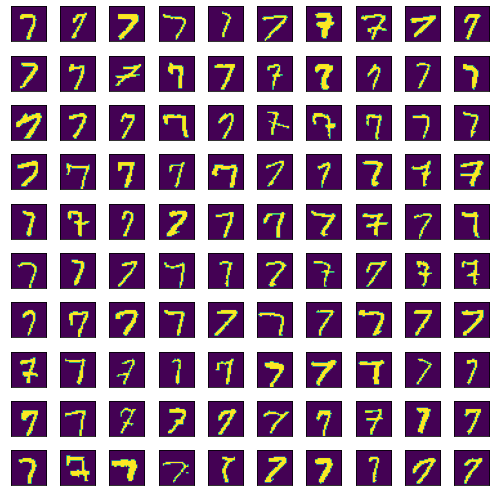

In [6]:
def plot_images(data, rows=4, cols=4, figsize=(7,7)):
    # For a stack of images `data` (3d-array), plot `rows`x`cols` randomly selected examples
    
    fig, axs = plt.subplots(rows,cols,figsize=figsize)

    for ax_row in axs: 
        for ax in ax_row:
            idx = random.randint(0,len(data)) 
            ax.imshow(data[idx])
            ax.set_xticks([])
            ax.set_yticks([])
    fig.tight_layout() 
    plt.show()

# Plot some example digits
plot_images(trainData["7"], rows=10, cols=10)

## Gibbs sampling

The RBM distribution $p_{\theta}(\vec v, \vec h)$ has the useful property that the conditional distributions of hidden or visible units factorize as

$$
p(\vec v|\vec h)=\prod_ip(v_i|\vec h)\\
p(\vec h|\vec v)=\prod_\mu p(h_\mu|\vec v)
$$

with

$$
p(v_i=1|\vec h)=\sigma(a_i+\sum_\mu W_{i\mu}h_\mu)\\
p(h_\mu=1|\vec v)=\sigma(b_\mu+\sum_i W_{i\mu}v_i)
$$

and the sigmoid function

$$
\sigma(x) = \frac{1}{1+e^{-x}}
$$

This enables a Markov Chain Monte Carlo scheme called **Gibbs** sampling, where realizations of $\vec v$ and $\vec h$ are sampled *directly* using the conditional distributions above, see Fig. 62 in ["A high-bias, low-variance introduction to Machine Learning for physicists"](https://arxiv.org/abs/1803.08823).

**Let's implement this:**

*Hint:* Given the a `jax.random.PRNGKey` and a vector of Bernoulli probabilites `jax.random.bernoulli` ([documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.bernoulli.html#jax.random.bernoulli)) generates a sample of corresponding outcomes. The returned data type is `bool` - we should cast it to an `int` type.

The sigmoid function is implemented in jax under `jax.nn.sigmoid`.

In [11]:
def p_h_given_v(v, W, b):
    # Compute the vector p(h_mu | v)
    
    return jax.nn.sigmoid(b + jnp.dot(jnp.transpose(W), v))


def p_v_given_h(h, W, a):
    # Compute the vector p(v_i | h)
    
    return jax.nn.sigmoid(a + jnp.dot(W, h))


def gibbs_step(v, W, a, b, key):
    # This function performs one step of Gibbs sampling by sampling
    # a new hidden outcome followed by a new outcome of visible units
    #
    # Input arguments:  v - starting configuration of visible units
    #                   key - jax.random.PRNGKey

    # sample a realization from p(h_mu | v)
    
    h = jax.random.bernoulli(key, p_h_given_v(v, W, b)).astype(jnp.int32)
    
    # sample a realization from p(v_i | h)
    
    k1, key = jax.random.split(key)
    
    v_new = jax.random.bernoulli(k1, p_v_given_h(h, W, a)).astype(jnp.int32)
    
    return v_new


@partial(jax.jit, static_argnums=(5,))               # JIT for performance; `n` has to be static because of loop
@partial(jax.vmap,in_axes=(0,None,None,None,0,None)) # Vectorization of the first dimension of `v` and `key`
def gibbs_sample(v, W, a, b, key, n):
    # Starting from a visible configuration `v` this function performs
    # `n` steps of Gibbs sampling and returns the new configuration
    sample = v
    
    for j in range(n):
        k1, key = jax.random.split(key)
        sample = gibbs_step(sample, W, a, b, k1)
        
    return sample

## Gradients with Contrastive Divergence

Due to the particular form of the RBM, the gradients of our cost function (log-likelihood) have a simple form:

$$
\frac{\partial\mathcal L(W,\vec a, \vec b)}{\partial W_{i\mu}}
=
\langle v_ih_\mu\rangle_{\text{data}}-\langle v_ih_\mu\rangle_{\text{model}}
\\
\frac{\partial\mathcal L(W,\vec a, \vec b)}{\partial a_i}
=
\langle v_i\rangle_{\text{data}}-\langle v_i\rangle_{\text{model}}
\\
\frac{\partial\mathcal L(W,\vec a, \vec b)}{\partial b_\mu}
=
\langle h_\mu\rangle_{\text{data}}-\langle h_\mu\rangle_{\text{model}}
$$

Here, $\langle \cdot\rangle_{\text{data}}$ denotes a mean over the training data and $\langle \cdot\rangle_{\text{model}}$ denotes the mean over a sample drawn from our RBM distribution $p_{\theta}(\vec v)$. Since $p(\vec v, \vec h)=p(\vec v)p(\vec h|\vec v)$ and $h_\mu\in\{0,1\}$, the empirical means can be rewritten, e.g. as

$$
\langle v_ih_\mu\rangle_{\mathcal S}=\frac{1}{|\mathcal S|}\sum_{\vec v\in\mathcal S} v_ip_\theta(h_\mu|\vec v)
$$

where $\mathcal S$ denotes the training data set or a sample drawn from $p_{\theta}(\vec v)$.

**Let's implement this:**

In [13]:
@partial(jax.vmap,in_axes=(0, None, None))
def wgrad_helper(v, W, b):
    return jnp.outer(v, p_h_given_v(v,W,b))


@partial(jax.vmap,in_axes=(0, None, None))
def bgrad_helper(v, W, b):
    return p_h_given_v(v,W,b)
    

def pcd_gradients(batch, W, a, b, key, n=1, modelSample=None):
    # Arguments:
    # - batch: a batch of training data, 3d-array of shape (batch size, 28, 28)
    
    batchSize = batch.shape[0]
    
    keys = jax.random.split(key, batch.shape[0])
    
    if modelSample is None:
        modelSample = batch
    
    # Sample outcomes from the RBM
    modelSample = gibbs_sample(modelSample.reshape((batchSize, -1)), W, a, b, keys, n)
    
    # Flatten the input batch
    flatBatch = batch.reshape((batchSize, -1))
    
    W_grad = jnp.mean(wgrad_helper(flatBatch, W, b), axis=0) \
                - jnp.mean(wgrad_helper(modelSample, W, b), axis=0)
    
    a_grad = jnp.mean(flatBatch, axis=0) - jnp.mean(modelSample, axis=0)
    
    b_grad = jnp.mean(bgrad_helper(flatBatch, W, b), axis=0) \
                - jnp.mean(bgrad_helper(modelSample, W, b), axis=0)
    
    return W_grad, a_grad, b_grad, modelSample.reshape(batch.shape)

## Training loop

The function below implements the training loop.

Input parameters are

- `W`: weight matrix
- `a`: visible bias
- `b`: hidden bias
- `trainData`: Training data. 3-dimensional array, where the last two dimensions are image dimensions.
- `learningRate`: learning rate
- `numEpochs`: number of epochs for training
- `batchSize`: batchSize
- `cg_n`: number of iterations between samples in the Gibbs MCMC sampling
- `persistent`: boolean indicating whether to perform persistent contrastive divergence or not
- `seed`: seed for random number generator

The function returns the RBM parameters obtained at the end of training.

In [14]:
def train(W, a, b, trainData, learningRate=0.01, numEpochs=10, batchSize=128, cg_n=2, persistent=False, seed=1234):

    prng_key = jax.random.PRNGKey(seed)
    modelSample = None
    
    batchNumber = trainData.shape[0] // batchSize
    
    # Training loop over epochs
    for n in range(numEpochs):

        print("Epoch %d" % (n))

        # Generate randomly shuffled batches
        prng_key, tmp_key = jax.random.split(prng_key) # jax-style treatment of random numbers
        batches = jax.random.permutation(tmp_key, trainData)[:batchNumber*batchSize]
        batches = batches.reshape(-1,batchSize,28,28)

        for batch in batches:

            prng_key, tmp_key = jax.random.split(prng_key)

            if not persistent:
                modelSample = None
            
            # Compute gradients
            Wg, ag, bg, modelSample = pcd_gradients(batch, W, a, b, tmp_key, n=cg_n, modelSample=modelSample)

            # Update parameters with gradients
            
            W += learningRate * Wg
            a += learningRate * ag
            b += learningRate * bg

        plot_images(modelSample) # Show some example images generated by the RBM
        
    return W, a, b

Finally, we are set to train the RBM

Epoch 0


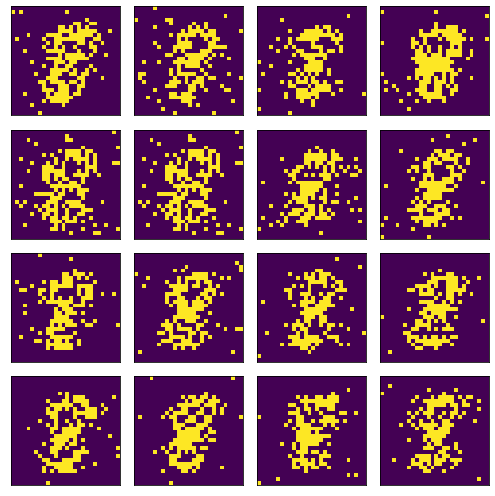

Epoch 1


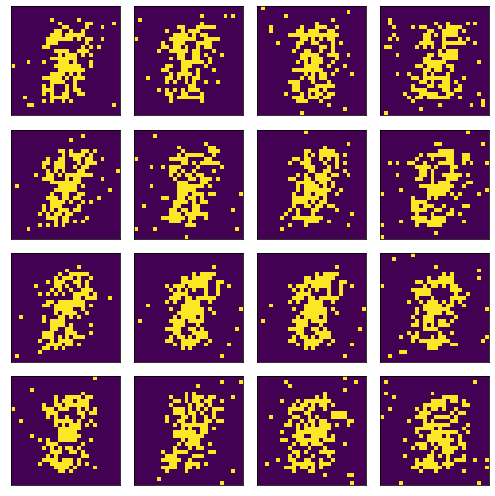

Epoch 2


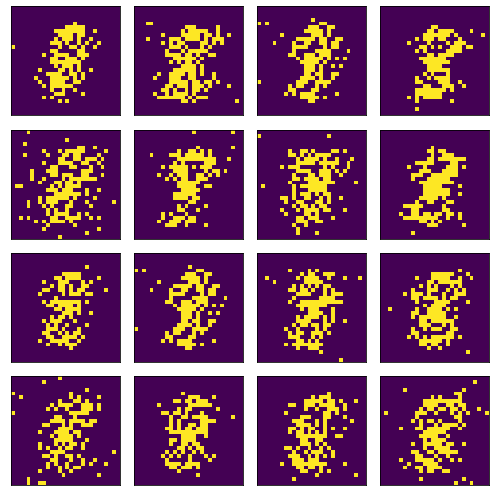

Epoch 3


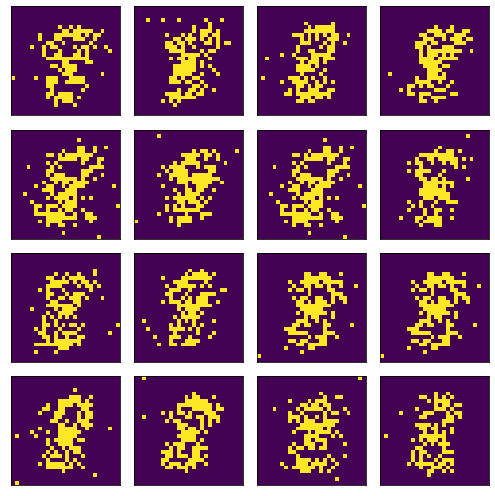

Epoch 4


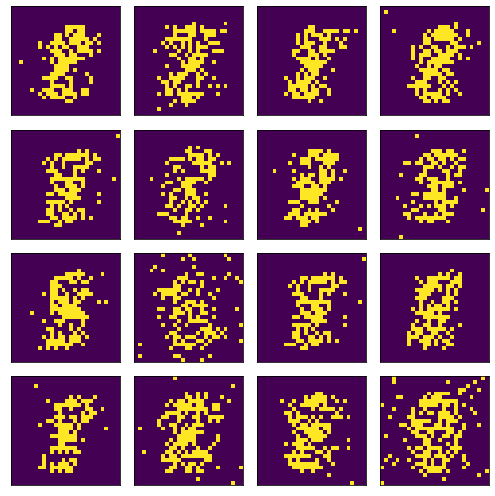

Epoch 5


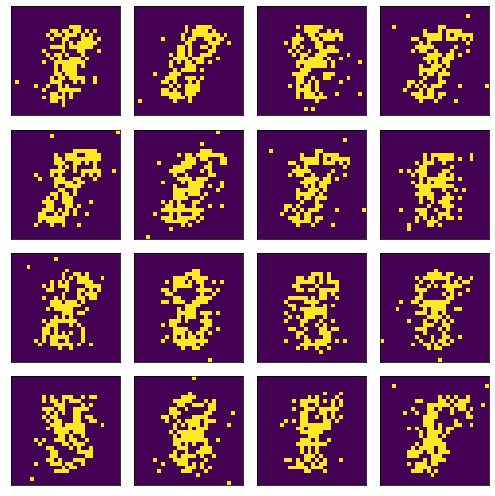

Epoch 6


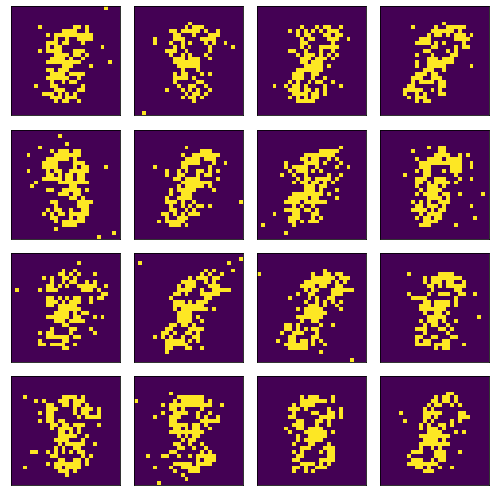

Epoch 7


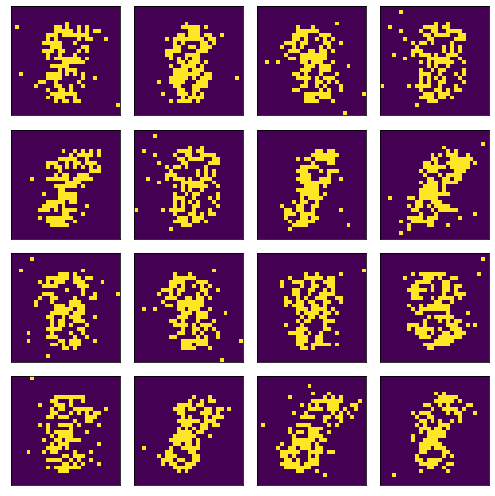

Epoch 8


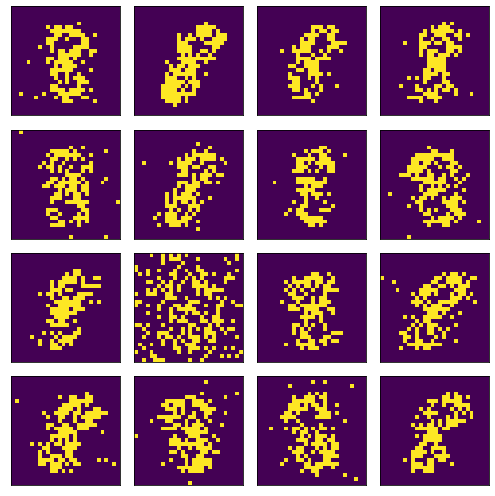

Epoch 9


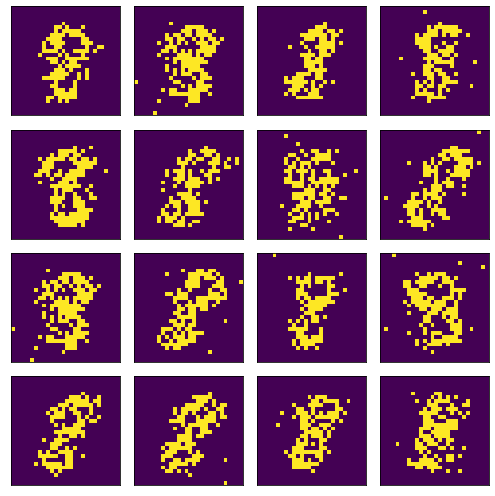

Epoch 10


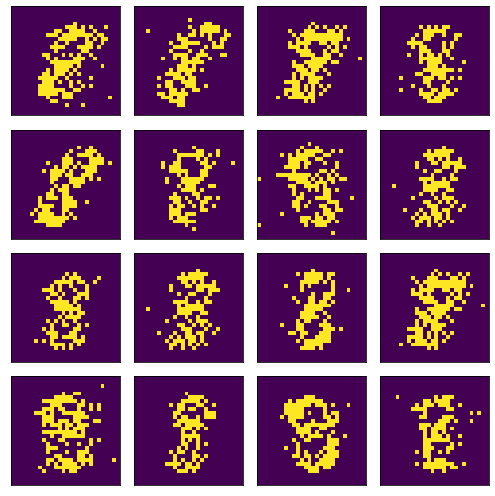

Epoch 11


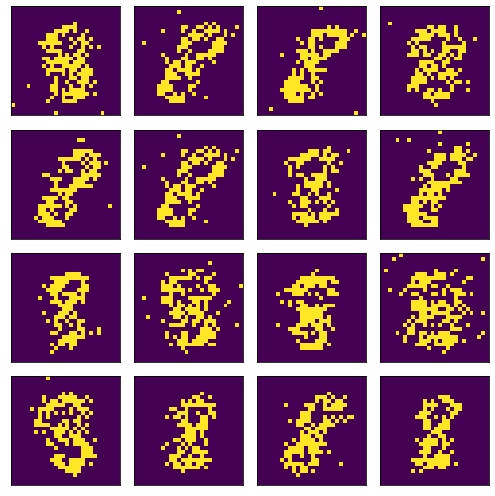

Epoch 12


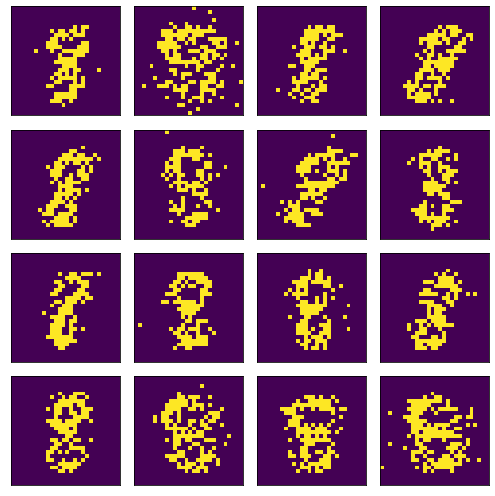

Epoch 13


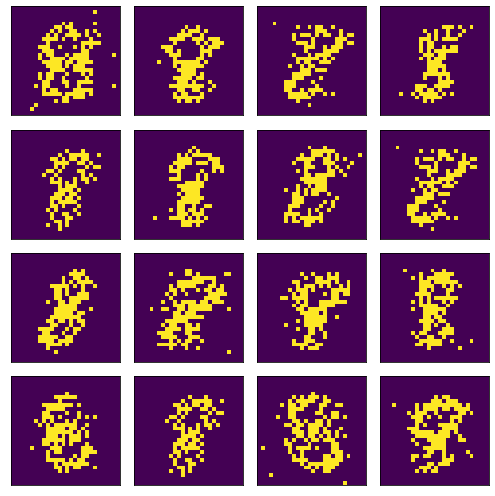

Epoch 14


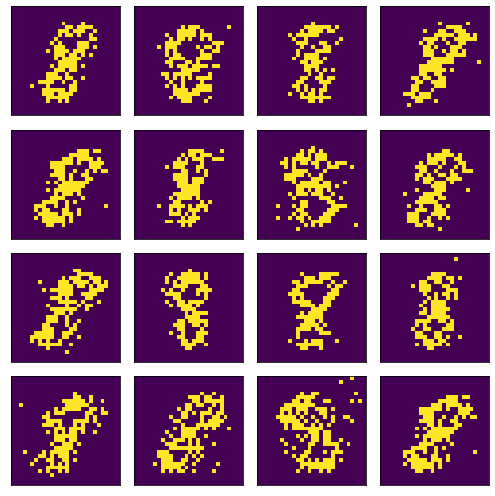

Epoch 15


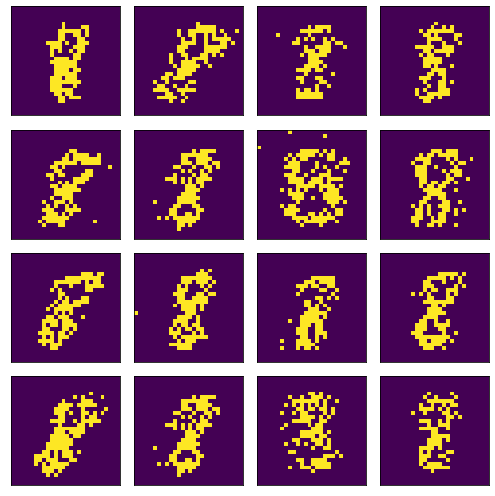

Epoch 16


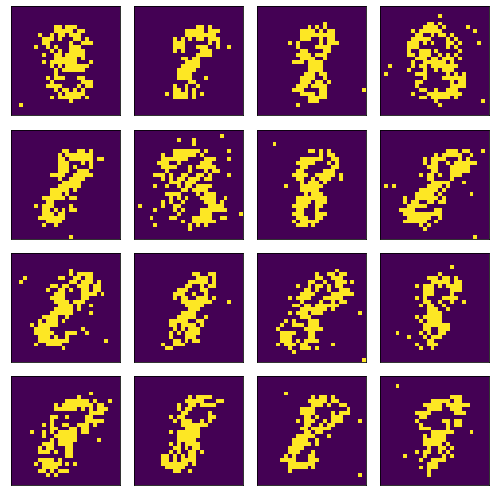

Epoch 17


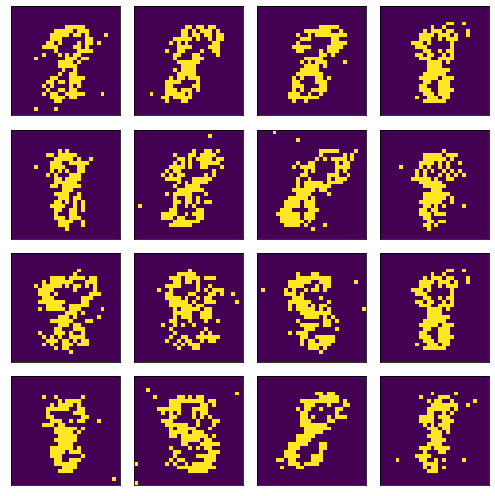

Epoch 18


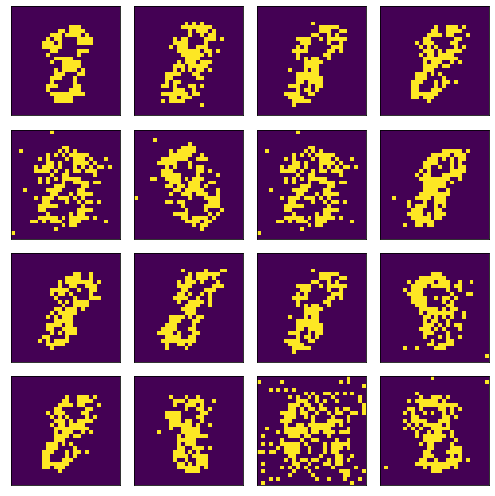

Epoch 19


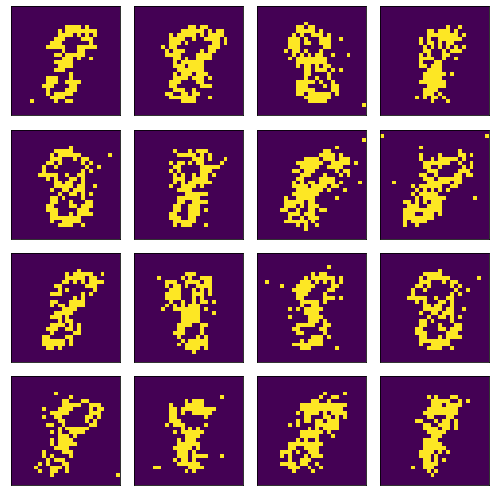

In [15]:
numVisible = 28*28
numHidden = 256 # number of hidden units

# Random initialization of parameters:
W = 0.01 * jax.random.normal(jax.random.PRNGKey(1234), (numVisible, numHidden))
a = jnp.zeros((numVisible,))
b = jnp.zeros((numHidden,))

# Run training
W, a, b = train(W, a, b, trainData["8"], numEpochs=20)

## Inspecting the features

Now we can inspect which features were learned in the weight matrix $W$ by plotting individual lines reshaped to the image dimensions:

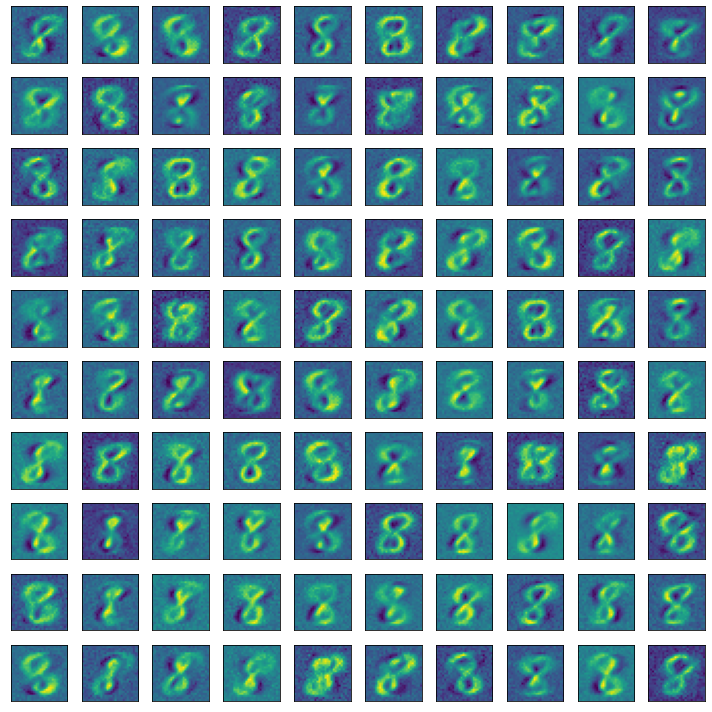

In [16]:
plot_images(jnp.transpose(W).reshape(-1,28,28), rows=10, cols=10, figsize=(10,10))

## Learning multiple digits

The RBM can not only learn to generate one single digit. Let's learn two at a time:

Epoch 0


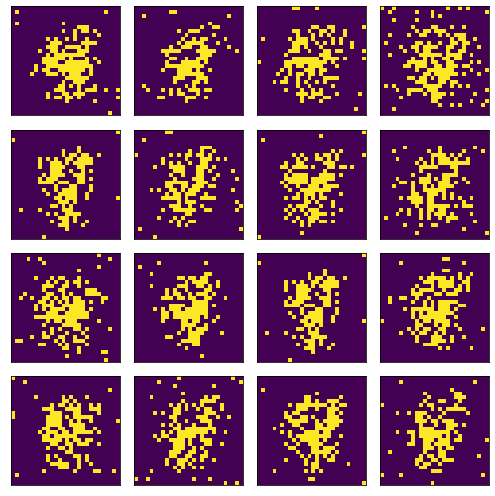

Epoch 1


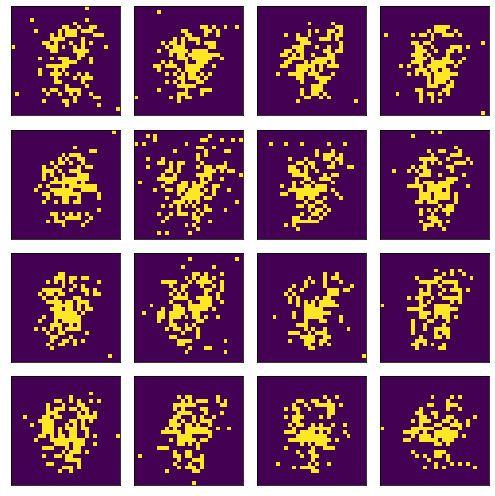

Epoch 2


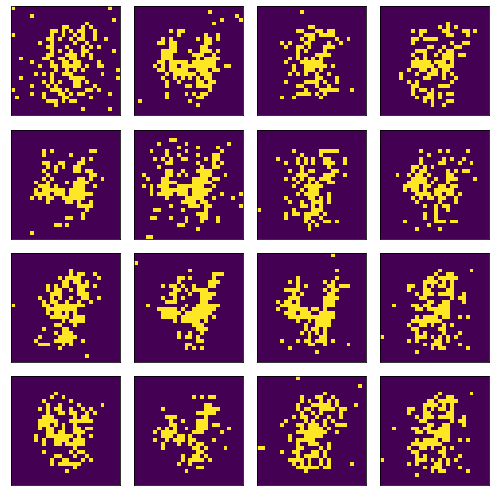

Epoch 3


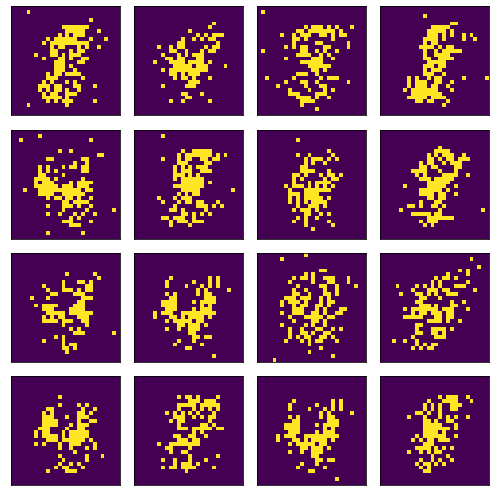

Epoch 4


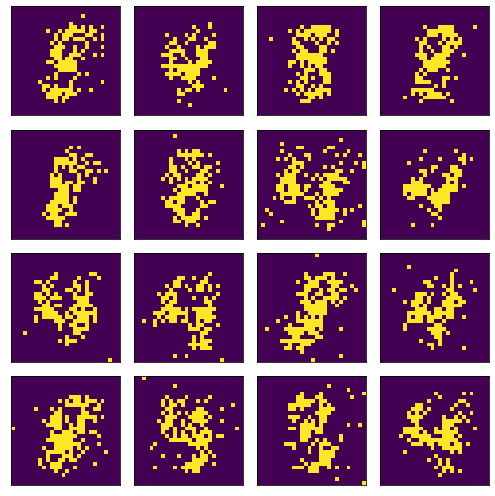

Epoch 5


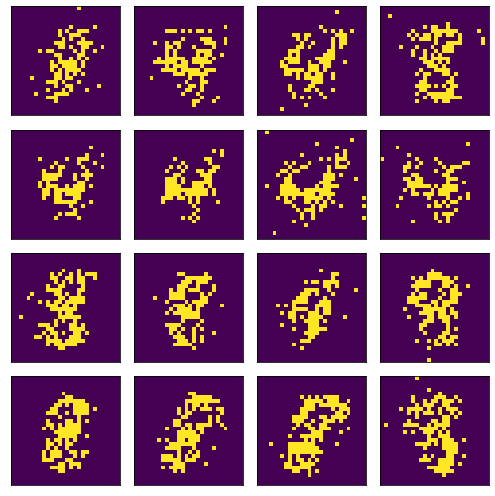

Epoch 6


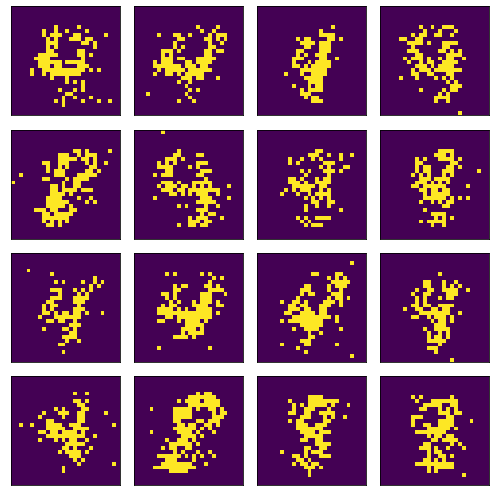

Epoch 7


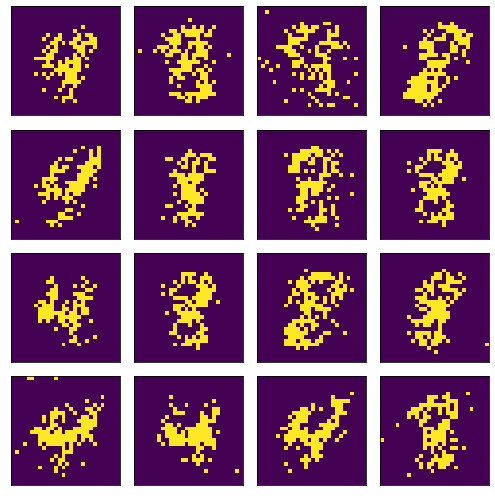

Epoch 8


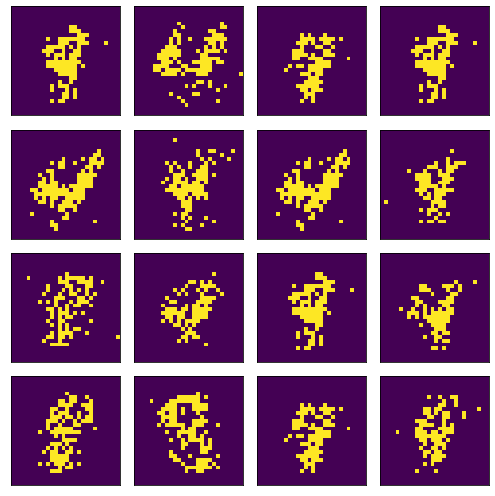

Epoch 9


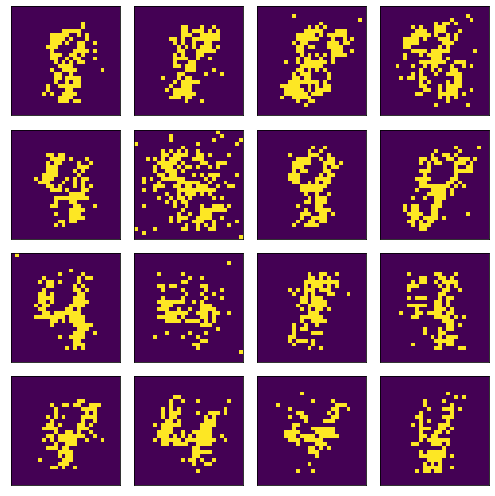

Epoch 10


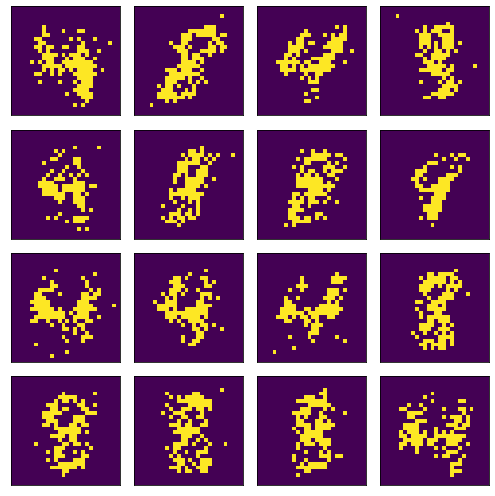

Epoch 11


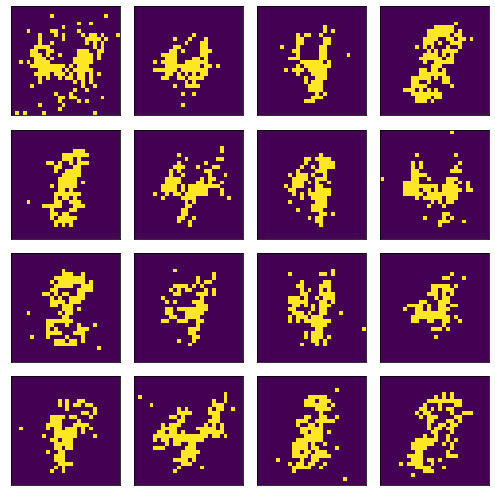

Epoch 12


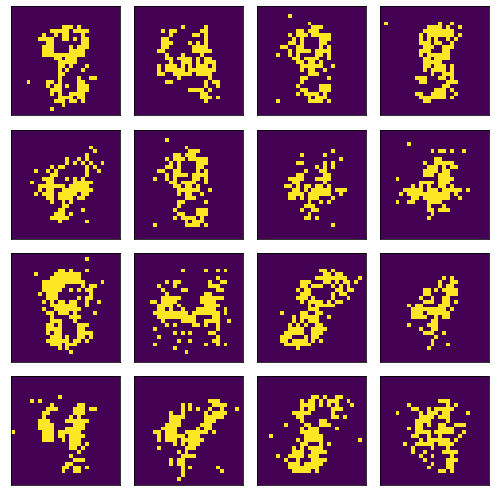

Epoch 13


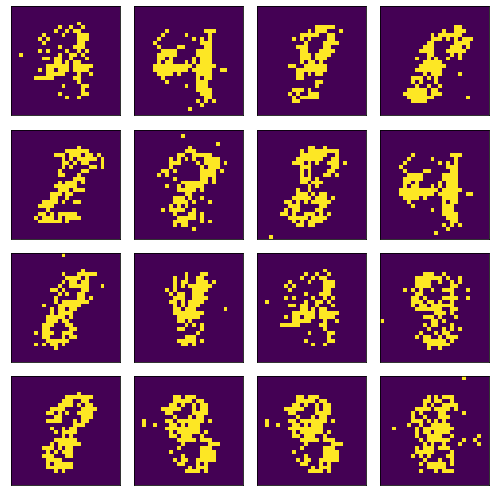

Epoch 14


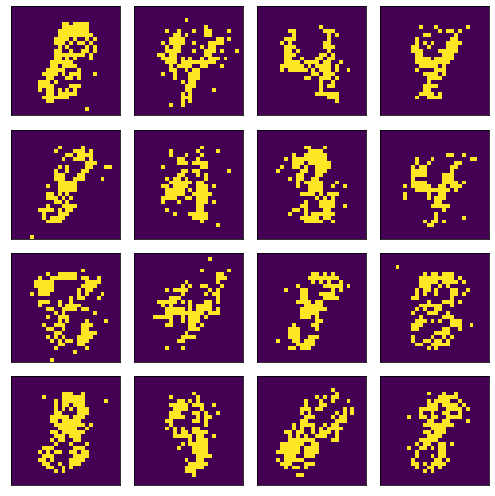

Epoch 15


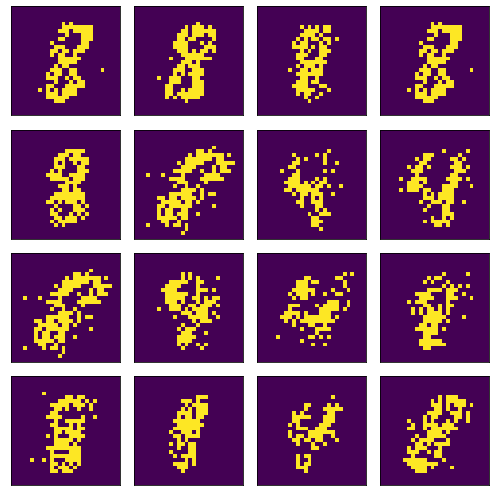

Epoch 16


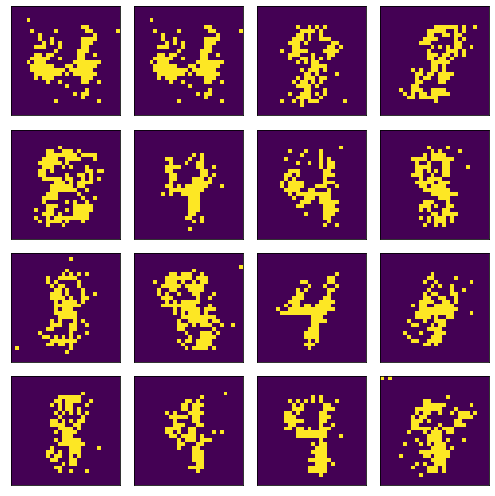

Epoch 17


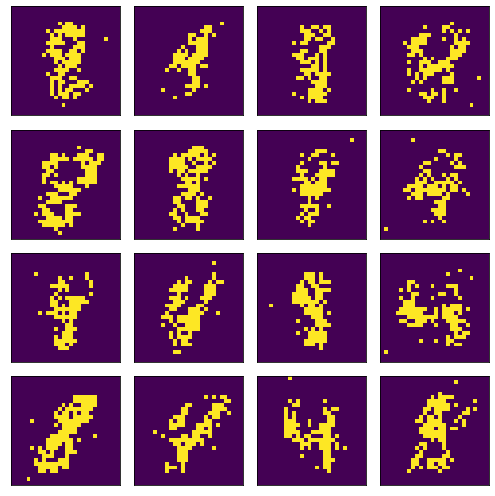

Epoch 18


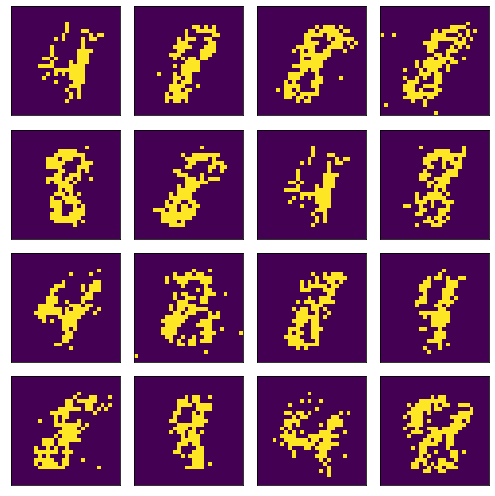

Epoch 19


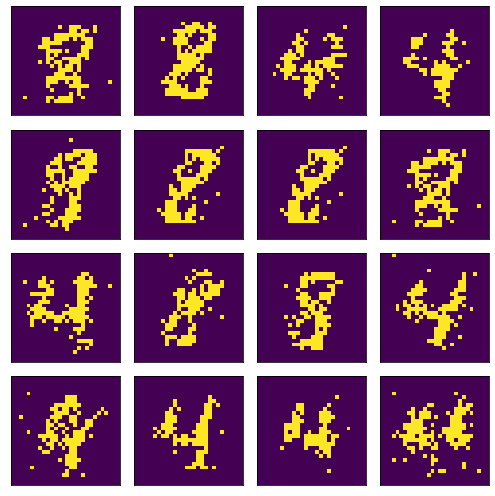

In [17]:
numVisible = 28*28
numHidden = 256 # number of hidden units

# Random initialization of parameters:
W = 0.01 * jax.random.normal(jax.random.PRNGKey(1234), (numVisible, numHidden))
a = jnp.zeros((numVisible,))
b = jnp.zeros((numHidden,))

examples = jnp.concatenate([trainData["8"], trainData["4"]])

# Run training
W, a, b = train(W, a, b, examples, numEpochs=20)

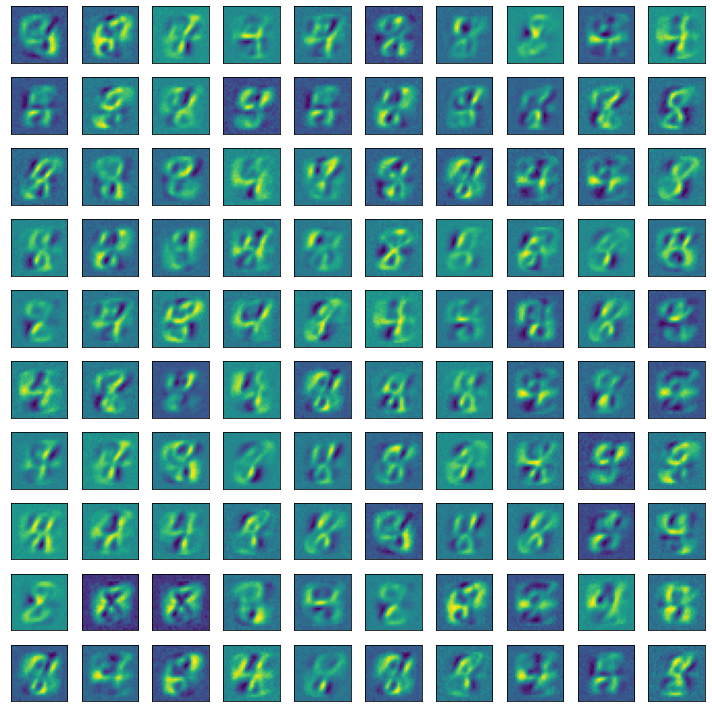

In [18]:
plot_images(jnp.transpose(W).reshape(-1,28,28), rows=10, cols=10, figsize=(10,10))